## Prepare the dataset

In [40]:
import numpy as np
import matplotlib.pyplot as plt


# generate sin function as a time series length of 4000, input the amplitude, period and phase shift

def sin_function(amp,period,phase_shift):
    x=np.arange(4000)
    y=amp*np.sin(2*np.pi*x/period+phase_shift)
    return y

# generate y as an array of zeros

y=np.zeros(4000)

In [41]:
# add a sin wave to y with a period of 120 as base frequency

y= y + sin_function(1,120,0)

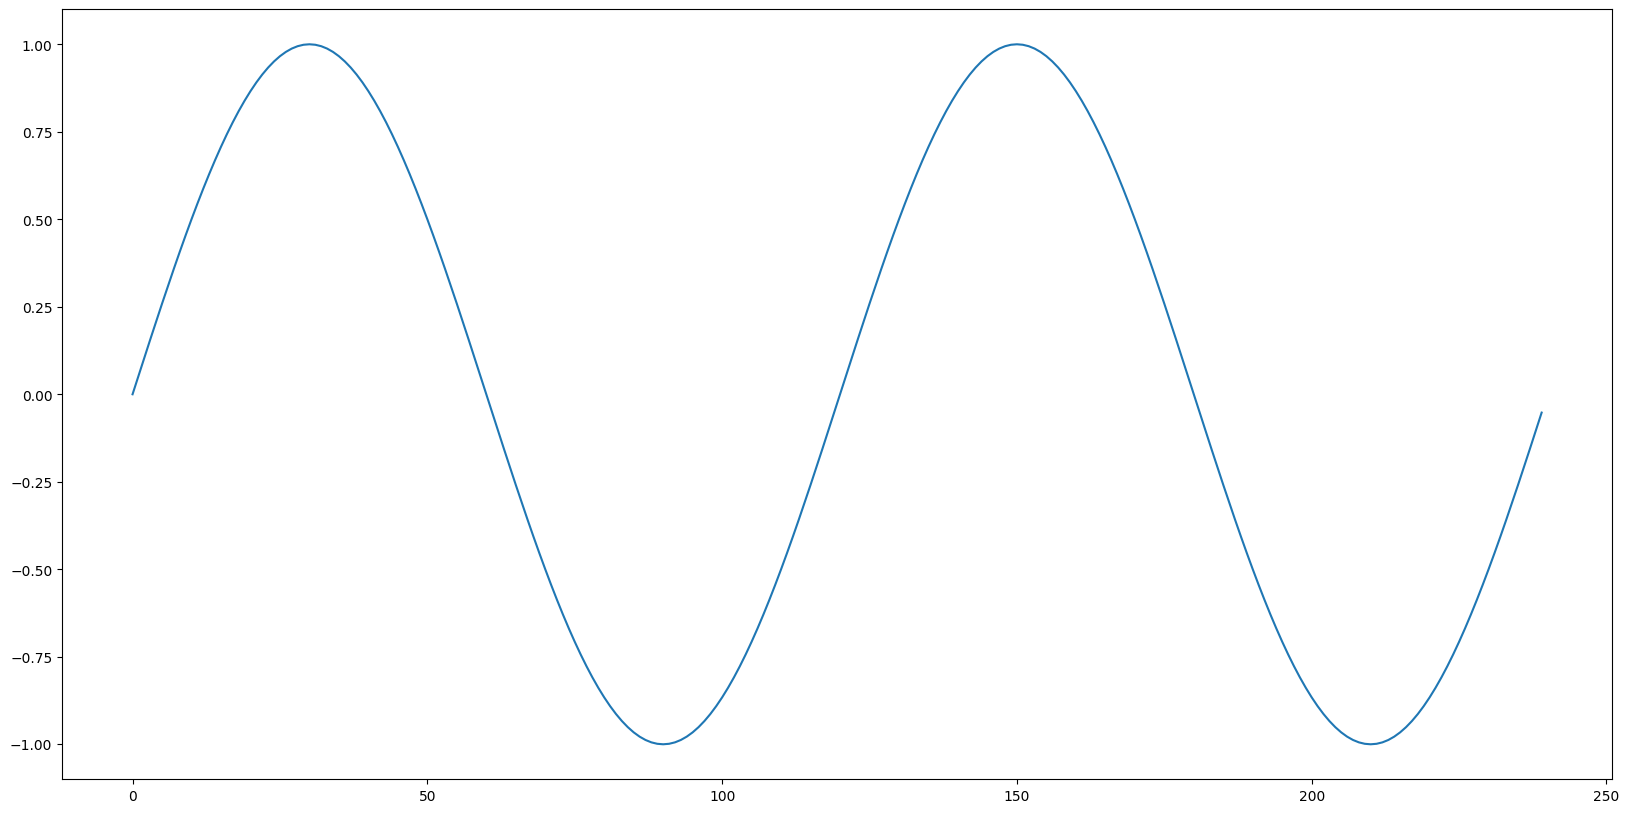

In [42]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y[:240])

In [43]:
# 2nd harmonic
y+= sin_function(0.5, 60, np.pi/2)

# 4th harmonic
y+= sin_function(0.7, 30, np.pi/4)

# 5th harmonic
y+= sin_function(0.3, 24, np.pi/3)

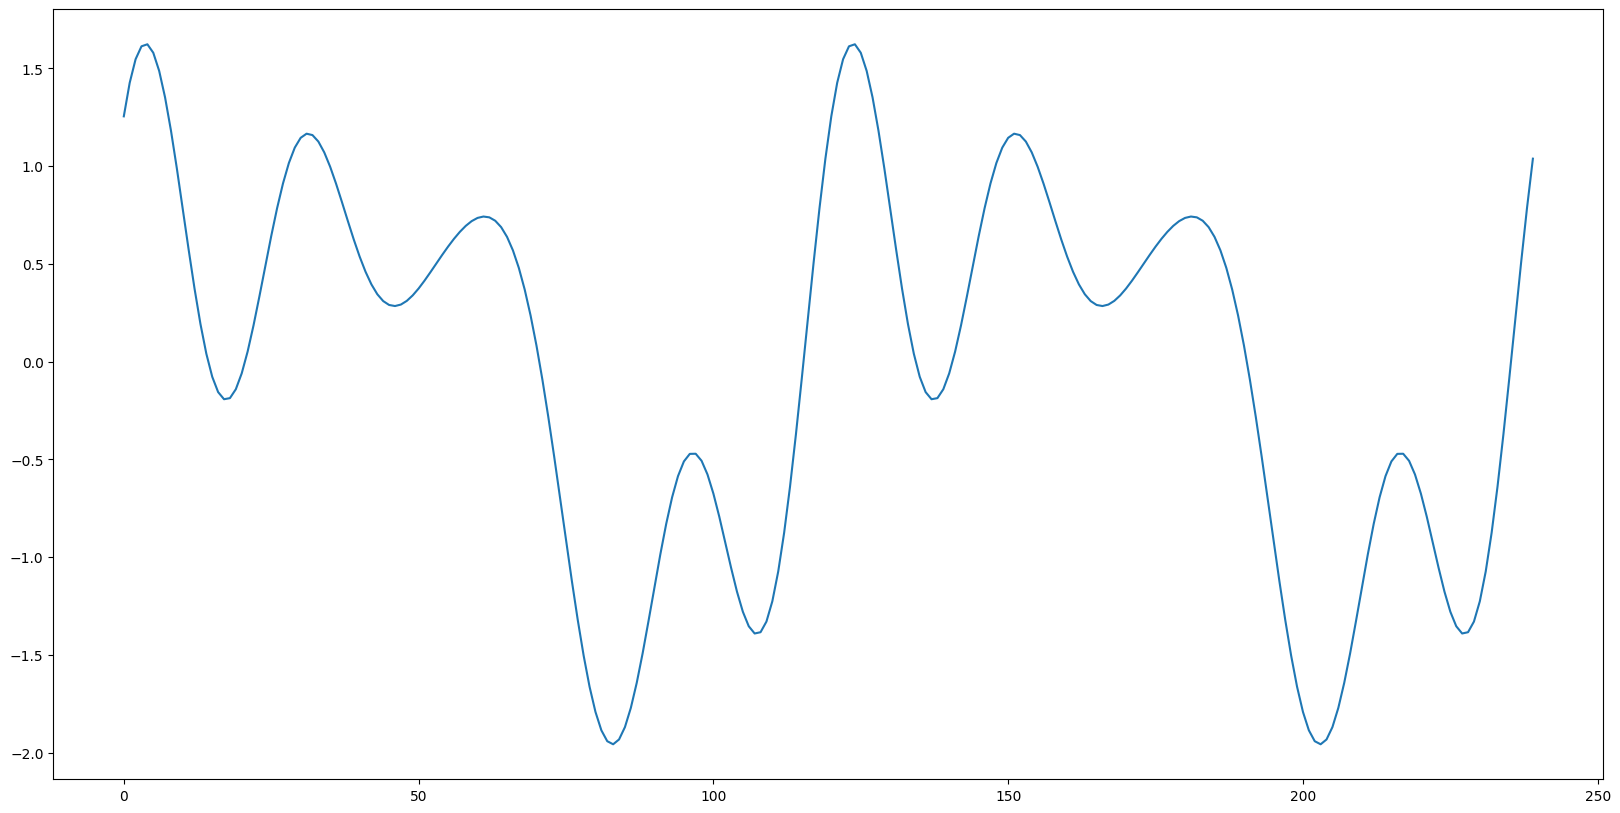

In [44]:
plt.figure(figsize=(20,10))
plt.plot(y[:240])

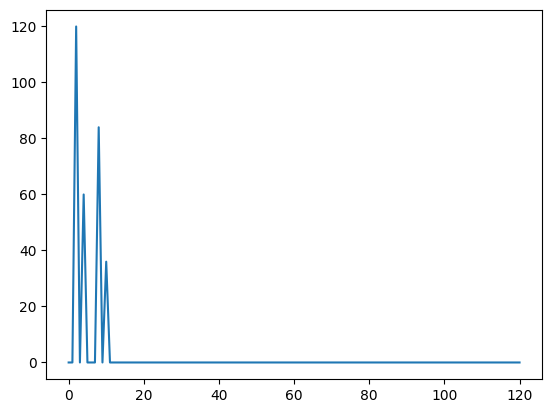

In [45]:
# inspect the spectrum

plt.plot(np.abs(np.fft.rfft(y[:240])))

The peaks appers at frequency 2, 4, 8, 10 as excepted. Because 240 is two base period of 120. 

## Prepare the FITS

In [46]:
from models.FITS import Model



In [47]:
class Config(object):

    def __init__(self, seq_len=240, pred_len=120, individual=False, enc_in=1, cut_freq=20):
        self.seq_len=seq_len
        self.pred_len=pred_len
        self.individual=individual
        self.enc_in=enc_in
        self.cut_freq=cut_freq

In [48]:
config=Config()
model=Model(config).to('cuda:0')
# initiate the model parameters as 0 for better visualization
for param in model.parameters():
    param.data.fill_(0)

In [49]:
print(model)

Model(
  (freq_upsampler): Linear(in_features=20, out_features=30, bias=True)
)


## Prepare the training

In [50]:
from torch import optim
from utils.metrics import metric
from torch import nn
import torch

In [51]:
model_optim=optim.Adam(model.parameters(),lr=1e-4)
criterion=nn.MSELoss()

## train the FITS on synthetic data

In [52]:
for epoch in range(1000): # train 1000 epochs
    order=np.random.permutation(2000) # shuffle the training sample
    train_loss=[]
    for batch in range(25): # split each epoch into 25 batches
        batch_start=order[batch*80:(batch+1)*80] # each batch has 80 samples
        batch=[]
        for i in batch_start:
            batch.append(y[i:i+240+120])
        batch_xy=np.array(batch).reshape(80,360,1) # 80 batch_size, 360 time steps, 1 feature

        batch_xy=torch.from_numpy(batch_xy).float().to('cuda:0')

        batch_x=batch_xy[:,:240,:]
        batch_y=batch_xy[:,240:,:]

        model_optim.zero_grad()

        output,low=model(batch_x)

        # output=output[:,-120:,:]

        loss=criterion(output,batch_xy) # supervise on xy (only supervise on y also achieve the same result)

        train_loss.append(loss.item())

        loss.backward()

        model_optim.step()

    print('epoch: ',epoch,' loss: ',np.mean(train_loss))



epoch:  0  loss:  0.9128327083587646
epoch:  1  loss:  0.908247287273407
epoch:  2  loss:  0.9036823916435242
epoch:  3  loss:  0.8991411662101746
epoch:  4  loss:  0.8946159172058106
epoch:  5  loss:  0.8901224970817566
epoch:  6  loss:  0.8856255674362182
epoch:  7  loss:  0.8811650395393371
epoch:  8  loss:  0.8767104077339173
epoch:  9  loss:  0.872276041507721
epoch:  10  loss:  0.8678699207305908
epoch:  11  loss:  0.8634511017799378
epoch:  12  loss:  0.859081130027771
epoch:  13  loss:  0.8547001338005066
epoch:  14  loss:  0.8503524374961853
epoch:  15  loss:  0.8460165524482727
epoch:  16  loss:  0.8416981506347656
epoch:  17  loss:  0.8373889064788819
epoch:  18  loss:  0.8331116127967835
epoch:  19  loss:  0.8288356566429138
epoch:  20  loss:  0.8245908260345459
epoch:  21  loss:  0.8203358459472656
epoch:  22  loss:  0.816109881401062
epoch:  23  loss:  0.8119050526618957
epoch:  24  loss:  0.8077159929275513
epoch:  25  loss:  0.803547797203064
epoch:  26  loss:  0.799375

Training shows that the FITS fits the dataset with zero loss. Because FITS is designed to fits sinosodial waves on different frequency. 

In [53]:
output=output.cpu().detach().numpy()
batch_xy=batch_xy.cpu().detach().numpy()


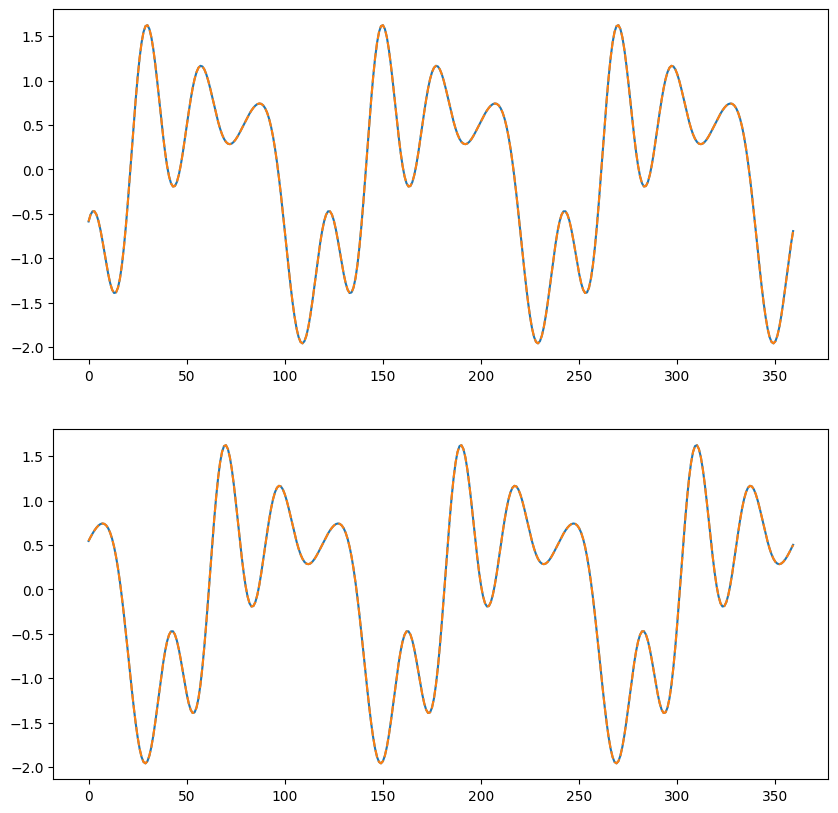

In [57]:
# Visualize the training result
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(output[0,:,0]) # prediction
plt.plot(batch_xy[0,:,0],'--') # ground truth
plt.subplot(2,1,2)
plt.plot(output[1,:,0])
plt.plot(batch_xy[1,:,0], '--')

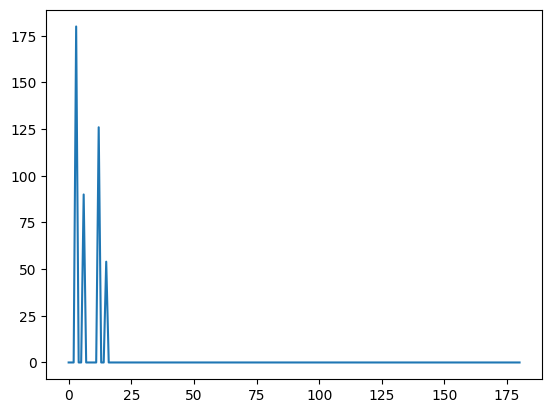

In [55]:
# inspect the spectrum of the output, shows the same peaks as the input as expected
plt.plot(np.abs(np.fft.rfft(output[0,:,0])))

The peaks move to 3, 6, 12, 15 respectively with corresponding scaling. Because the segment extend to 360 steps which is 3 base periodics. This shows that FITS learns to reposition the frequencies during forecasting task. Such behavior preserves the information in the input segment and predict the horizon according to the frequency distribution based on the input segment. 

## Test on the test set

In [75]:
with torch.no_grad():
    model.eval()
    test_loss=[]
    batch=[]

    for i in range(2360,4000-360):
        batch.append(y[i:i+240+120])
    batch_xy=np.array(batch).reshape(-1,360,1) # 80 batch_size, 360 time steps, 1 feature

    batch_xy=torch.from_numpy(batch_xy).float().to('cuda:0')

    batch_x=batch_xy[:,:240,:]
    batch_y=batch_xy[:,240:,:]

    model_optim.zero_grad()

    output,low=model(batch_x)

    # output=output[:,-120:,:]

    loss=criterion(output,batch_xy) # supervise on xy (only supervise on y also achieve the same result)

    test_loss.append(loss.item())


    print('epoch: test loss: ',np.mean(test_loss))

epoch: test loss:  1.9431221076615657e-09


The test result also shows FITS fits the dataset well!

In [76]:
output=output.cpu().detach().numpy()
batch_xy=batch_xy.cpu().detach().numpy()

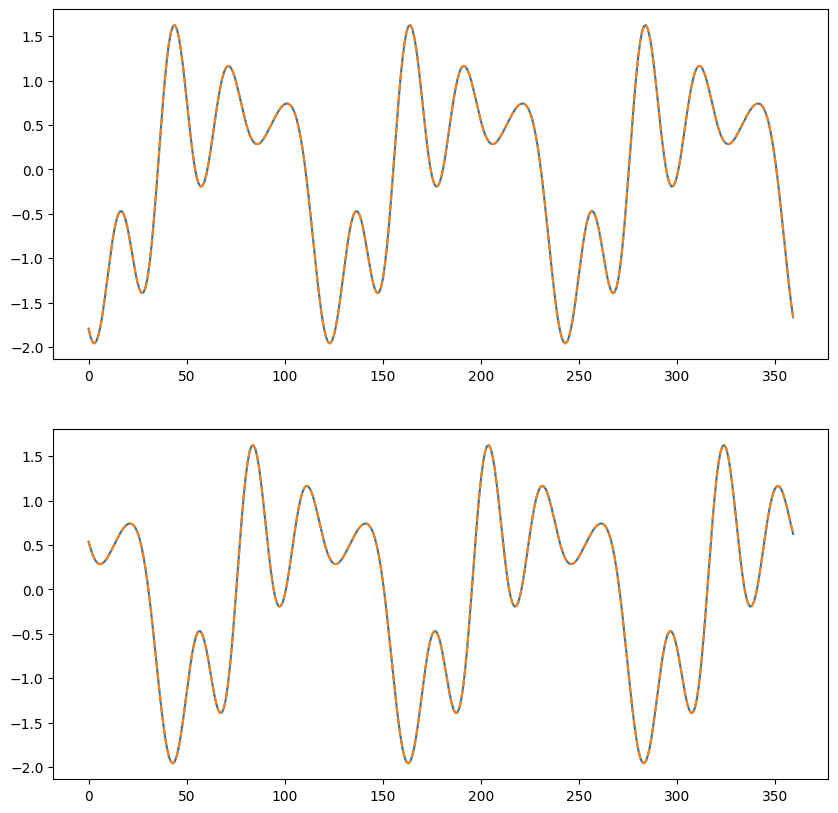

In [77]:
# Visualize the training result
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(output[0,:,0]) # prediction
plt.plot(batch_xy[0,:,0],'--') # ground truth
plt.subplot(2,1,2)
plt.plot(output[200,:,0])
plt.plot(batch_xy[200,:,0], '--')

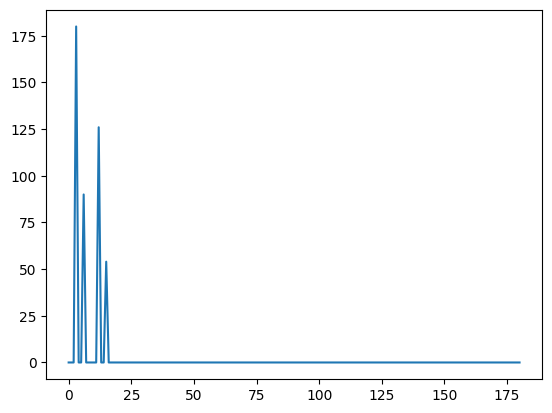

In [62]:
# inspect the spectrum of the output, shows the same peaks as the input as expected
plt.plot(np.abs(np.fft.rfft(output[0,:,0])))

The peaks move to 3, 6, 12, 15 respectively with corresponding scaling. Because the segment extend to 360 steps which is 3 base periodics. This shows that FITS learns to reposition the frequencies during forecasting task. Such behavior preserves the information in the input segment and predict the horizon according to the frequency distribution based on the input segment. 

## Frequency response test

In [104]:
# create a sine wave on the base frequency
# y2=sin_function(1, 120, 0)[:360]+sin_function(0.5, 60, np.pi/2)[:360]+sin_function(0.7, 30, np.pi/4)[:360]+sin_function(0.3, 24, np.pi/3)[:360] # original waveform
y1=sin_function(1, 120, 0)[:360]
y1=y1.reshape(1,360,1)
y1=torch.tensor(y1, dtype=torch.float32).to('cuda:0')

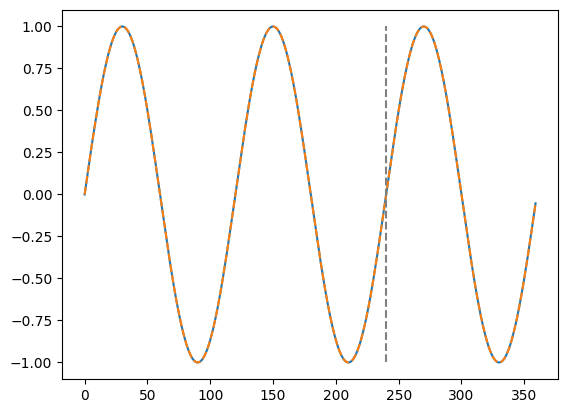

In [106]:
# put it into trained FITS

with torch.no_grad():
    model.eval()
    batch_x1=y1[:,:240,:]
    output, _=model(batch_x1)
    output=output.cpu().numpy()
    plt.plot(output[0,:,0], label='output')
    plt.plot(y1[0,:,0].cpu().numpy(), '--')
    plt.vlines(240, -1, 1, colors='grey', linestyles='dashed')

We find FITS can perfectly perform forecasting on a series pattern that is not seen in training. This is because FITS forecast on the frequency components individually and then combine them together. 

**You can change the frequency, phase and amplitude of the sine wave to see how FITS performs on different patterns.**

In [110]:
# create a wavelet of the combination of two frequency

y_mix=sin_function(1, 120, 0)[:360]+sin_function(2, 24, np.pi/2)[:360]
y_mix=y_mix.reshape(1,360,1)
y_mix=torch.tensor(y_mix, dtype=torch.float32).to('cuda:0')

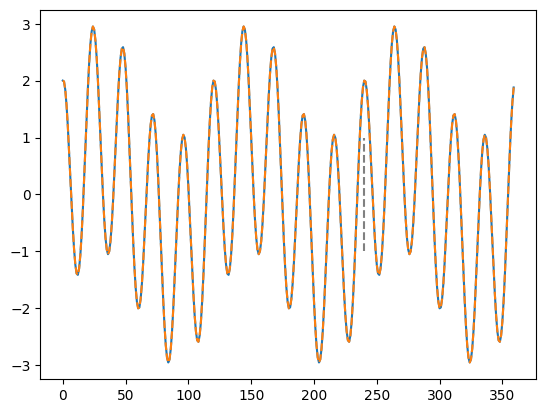

In [111]:
# put it into trained FITS

with torch.no_grad():
    model.eval()
    batch_x_mix=y_mix[:,:240,:]
    output, _=model(batch_x_mix)
    output=output.cpu().numpy()
    plt.plot(output[0,:,0], label='output')
    plt.plot(y_mix[0,:,0].cpu().numpy(), '--')
    plt.vlines(240, -1, 1, colors='grey', linestyles='dashed')

**FITS still can handle the any combination of seen frequency. This further prove that these frequency components are decoupled for FITS.**

We further test on the third harmonic of the base frequency. This frequency is not added in the training set. Thus, FITS cannot give a good output on it. 

In [107]:
# create a sine wave on the third harmonic frequency
# y2=sin_function(1, 120, 0)[:360]+sin_function(0.5, 60, np.pi/2)[:360]+sin_function(0.7, 30, np.pi/4)[:360]+sin_function(0.3, 24, np.pi/3)[:360] # original waveform
y3=sin_function(1, 40, 0)[:360]
y3=y3.reshape(1,360,1)
y3=torch.tensor(y3, dtype=torch.float32).to('cuda:0')

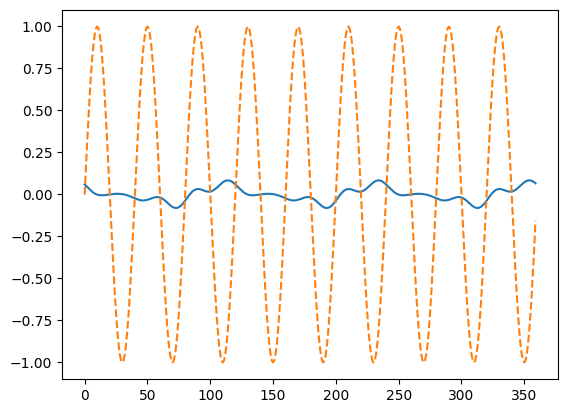

In [108]:
# put it into trained FITS

with torch.no_grad():
    model.eval()
    batch_x3=y3[:,:240,:]
    output, _=model(batch_x3)
    output=output.cpu().numpy()
    plt.plot(output[0,:,0], label='output')
    plt.plot(y3[0,:,0].cpu().numpy(), '--')